In [1]:
from GNNTrain import train, predict_from_saved_model
from CreateDatasetv2_binary import get_dataset_from_graph
from Paths import PATH_TO_GRAPHS, PATH_TO_RANKINGS
from GDARanking import get_ranking, get_ranking_from_all_positives, validate_with_extended_dataset
from GraphSageModel import GNN7L_Sage

import pandas as pd

In [2]:
disease_Id  = 'C0006142'
classes     = ['P', 'U']
model_name  = 'GraphSAGE_' + disease_Id + '_new_rankings_binary'
graph_path  = PATH_TO_GRAPHS + 'grafo_nedbit_' + disease_Id + '.gml'

In [3]:
dataset, G = get_dataset_from_graph(graph_path, disease_Id, quartile=False)

[+] Reading graph...ok
[+] Creating dataset...ok
[i] Elapsed time: 28.72


### Train

In [4]:
lr              = 0.001
epochs          = 40000
weight_decay    = 0.0005
classes         = ['P', 'U']

model = GNN7L_Sage(dataset)
preds = train(model, dataset, epochs, lr, weight_decay, classes, model_name)

  0%|          | 0/40001 [00:00<?, ?it/s]

[Epoch: 0000] train loss: 20.7379, train acc: 0.9312, val loss: 9.2713, val acc: 0.9481  (best train acc: 0.9312, best val acc: 0.9481, best train loss: 20.7379  @ epoch 0 )
[Epoch: 0020] train loss: 1.6296, train acc: 0.8947, val loss: 0.3517, val acc: 0.9477  (best train acc: 0.9312, best val acc: 0.9481, best train loss: 1.6296  @ epoch 20 )
[Epoch: 0040] train loss: 0.6390, train acc: 0.8987, val loss: 0.2481, val acc: 0.9437  (best train acc: 0.9312, best val acc: 0.9481, best train loss: 0.6390  @ epoch 40 )
[Epoch: 0060] train loss: 0.4008, train acc: 0.9223, val loss: 0.2355, val acc: 0.9352  (best train acc: 0.9312, best val acc: 0.9481, best train loss: 0.4008  @ epoch 60 )
[Epoch: 0080] train loss: 0.3311, train acc: 0.9087, val loss: 0.2213, val acc: 0.9450  (best train acc: 0.9312, best val acc: 0.9481, best train loss: 0.3288  @ epoch 79 )
[Epoch: 0100] train loss: 0.2906, train acc: 0.9297, val loss: 0.2249, val acc: 0.9420  (best train acc: 0.9312, best val acc: 0.9481,

### Get predictions from trained model

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       100
           1       0.72      0.95      0.82       757
           2       0.88      0.59      0.71       757
           3       0.87      0.86      0.86       757
           4       0.87      0.90      0.88       593

    accuracy                           0.83      2964
   macro avg       0.86      0.86      0.85      2964
weighted avg       0.84      0.83      0.82      2964



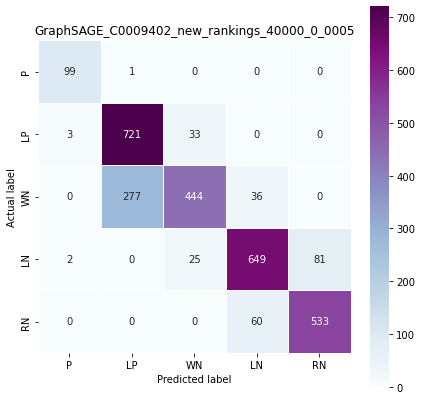

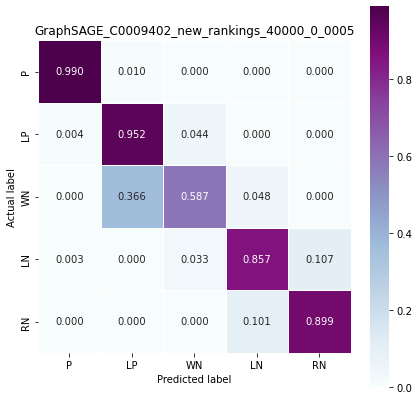

In [5]:
preds, probs, model = predict_from_saved_model(model_name + '_40000_0_0005', dataset, classes, save_to_file=False)

### Ranking

In [10]:
df = pd.read_csv('precision_positive_genes.csv') 
n_positives = n_positives = df['n_positives'][df[disease_Id].idxmax()]

preds, probs, model = predict_from_saved_model(model_name+'_40000_0_0005', dataset, classes, save_to_file=False, plot_results=False)

ranking = get_ranking(model, dataset, preds, probs, disease_Id, n_positive=n_positives, explanation_nodes_ratio=1, masks_for_seed=10, G=G)

### Save ranking to file
filename = PATH_TO_RANKINGS + disease_Id + '_' + str(n_positives) + '_new_rankings.txt'
with open(filename, 'w') as f:
    for line in ranking:
        f.write(line + '\n')

cuts = [25, 50, 100, 200, 500]
for k in cuts:
    precision = validate_with_extended_dataset(ranking[:k], disease_Id, save_ranking_to_file=False)
    print('[+] Precision on top', k, ':', precision/k)

  0%|          | 0/60 [00:00<?, ?it/s]

[+] Precision on top 25 : 0.72
[+] Precision on top 50 : 0.66
[+] Precision on top 100 : 0.67
[+] Precision on top 200 : 0.625
[+] Precision on top 500 : 0.53


### All positive genes

In [7]:
ranking = get_ranking_from_all_positives(model, dataset, preds, disease_Id, explanation_nodes_ratio=1, masks_for_seed=5, G=G)

[+] 672 positive nodes found in the graph


  0%|          | 0/672 [00:00<?, ?it/s]

In [8]:
### Save ranking to file
filename = PATH_TO_RANKINGS + disease_Id + '_all_positives_new_ranking.txt'
with open(filename, 'w') as f:
     for line in ranking:
        f.write(line + '\n')

In [9]:
cuts = [25, 50, 100, 200, 500]
for k in cuts:
    precision = validate_with_extended_dataset(ranking[:k], disease_Id, save_ranking_to_file=False)
    print('[+] Precision on top', k, ':', precision/k)

[+] Precision on top 25 : 0.68
[+] Precision on top 50 : 0.72
[+] Precision on top 100 : 0.66
[+] Precision on top 200 : 0.645
[+] Precision on top 500 : 0.574
